# Portfolio Rebalancing Strategies

This notebook demonstrates dynamic portfolio rebalancing strategies using the core Mean-CVaR optimization module. Rebalancing adapts portfolio weights in response to market changes, aiming to maintain optimal performance while accounting for transaction costs and turnover constraints. In this example, we implement a simple transaction cost model: transaction_cost = transaction_cost_factor * turnover, with turnover $=\lVert w-w_{pre} \rVert_1$. 

We compare two rebalancing triggers:
- [Percentage change](#percentage-change): Reoptimize when portfolio value drops below a threshold.
- [Drift from optimal](#drift-from-optimal): Reoptimize when current weights deviate from optimal weights by a specified norm.

Both strategies are benchmarked against a buy-and-hold baseline, and we evaluate performance using GPU (cuOpt) vs. CPU solvers.


In [1]:
import os
import numpy as np
import cvxpy as cp

from cufolio import rebalance
from cufolio.cvar_parameters import CvarParameters

In [2]:
# Global data settings.
# Define dataset paths and common parameters.
sp500_dataset_name = "sp500"
sp500_dataset_directory = f"../data/stock_data/{sp500_dataset_name}.csv"

global_titans_dataset_name = "global_titans"
global_titans_dataset_directory = f"../data/stock_data/{global_titans_dataset_name}.csv"

log_return_type = "LOG" 

In [3]:
# Define CVaR parameters for rebalancing with transaction costs and turnover constraints.
rebal_tc_cvar_params = CvarParameters(
    w_min=-0.3,
    w_max=0.8,
    c_min=0.1,
    c_max=0.4,
    L_tar=1.6,
    T_tar=0.5,        # Turnover constraint to limit trading activity.
    cvar_limit=None,
    risk_aversion=1,
    confidence=0.95,
    num_scen=10000,
    fit_type="kde"
)

## Strategy 1: Percentage Change Rebalancing
<a id='percentage-change'></a>

Re-optimization will be triggered if one of the following conditions hold: 
- the percent change of the portfolio value from the start of the testing period to the end drops below `pct_change_tolerance`;
- the cumulative percent change of the portfolio value since the *last postive* percent change backtest period drops below `pct_change_tolerance`

As a baseline, we use a 21-day look-forward window and 252-day look-back window for rolling optimization, with cuOpt as the GPU solver. One can try to switch the solver to a CPU solver but it will much slower. 


BASELINE (BUY & HOLD) ANALYSIS
Period: 2022-07-01 to 2024-05-01
Strategy: Single optimization at start
Setting parameter log_to_console to false

BASELINE COMPLETE
Final portfolio value: $0.98
Total return: +0.28%
Data points collected: 441

DYNAMIC REBALANCING ANALYSIS
Period: 2022-07-01 to 2024-05-01
Strategy: Percentage Change
Threshold: -0.005
Look-forward window: 21 days
Look-back window: 252 days
Setting parameter log_to_console to false
Rebalancing triggered on 2022-08-02 | Event #1 | Portfolio value: $0.98
Setting parameter log_to_console to false
Rebalancing triggered on 2022-09-30 | Event #2 | Portfolio value: $1.04
Setting parameter log_to_console to false
Rebalancing triggered on 2022-11-30 | Event #3 | Portfolio value: $1.02
Setting parameter log_to_console to false
Rebalancing triggered on 2022-12-30 | Event #4 | Portfolio value: $1.00
Setting parameter log_to_console to false
Rebalancing triggered on 2023-02-01 | Event #5 | Portfolio value: $0.97
Setting parameter log_to

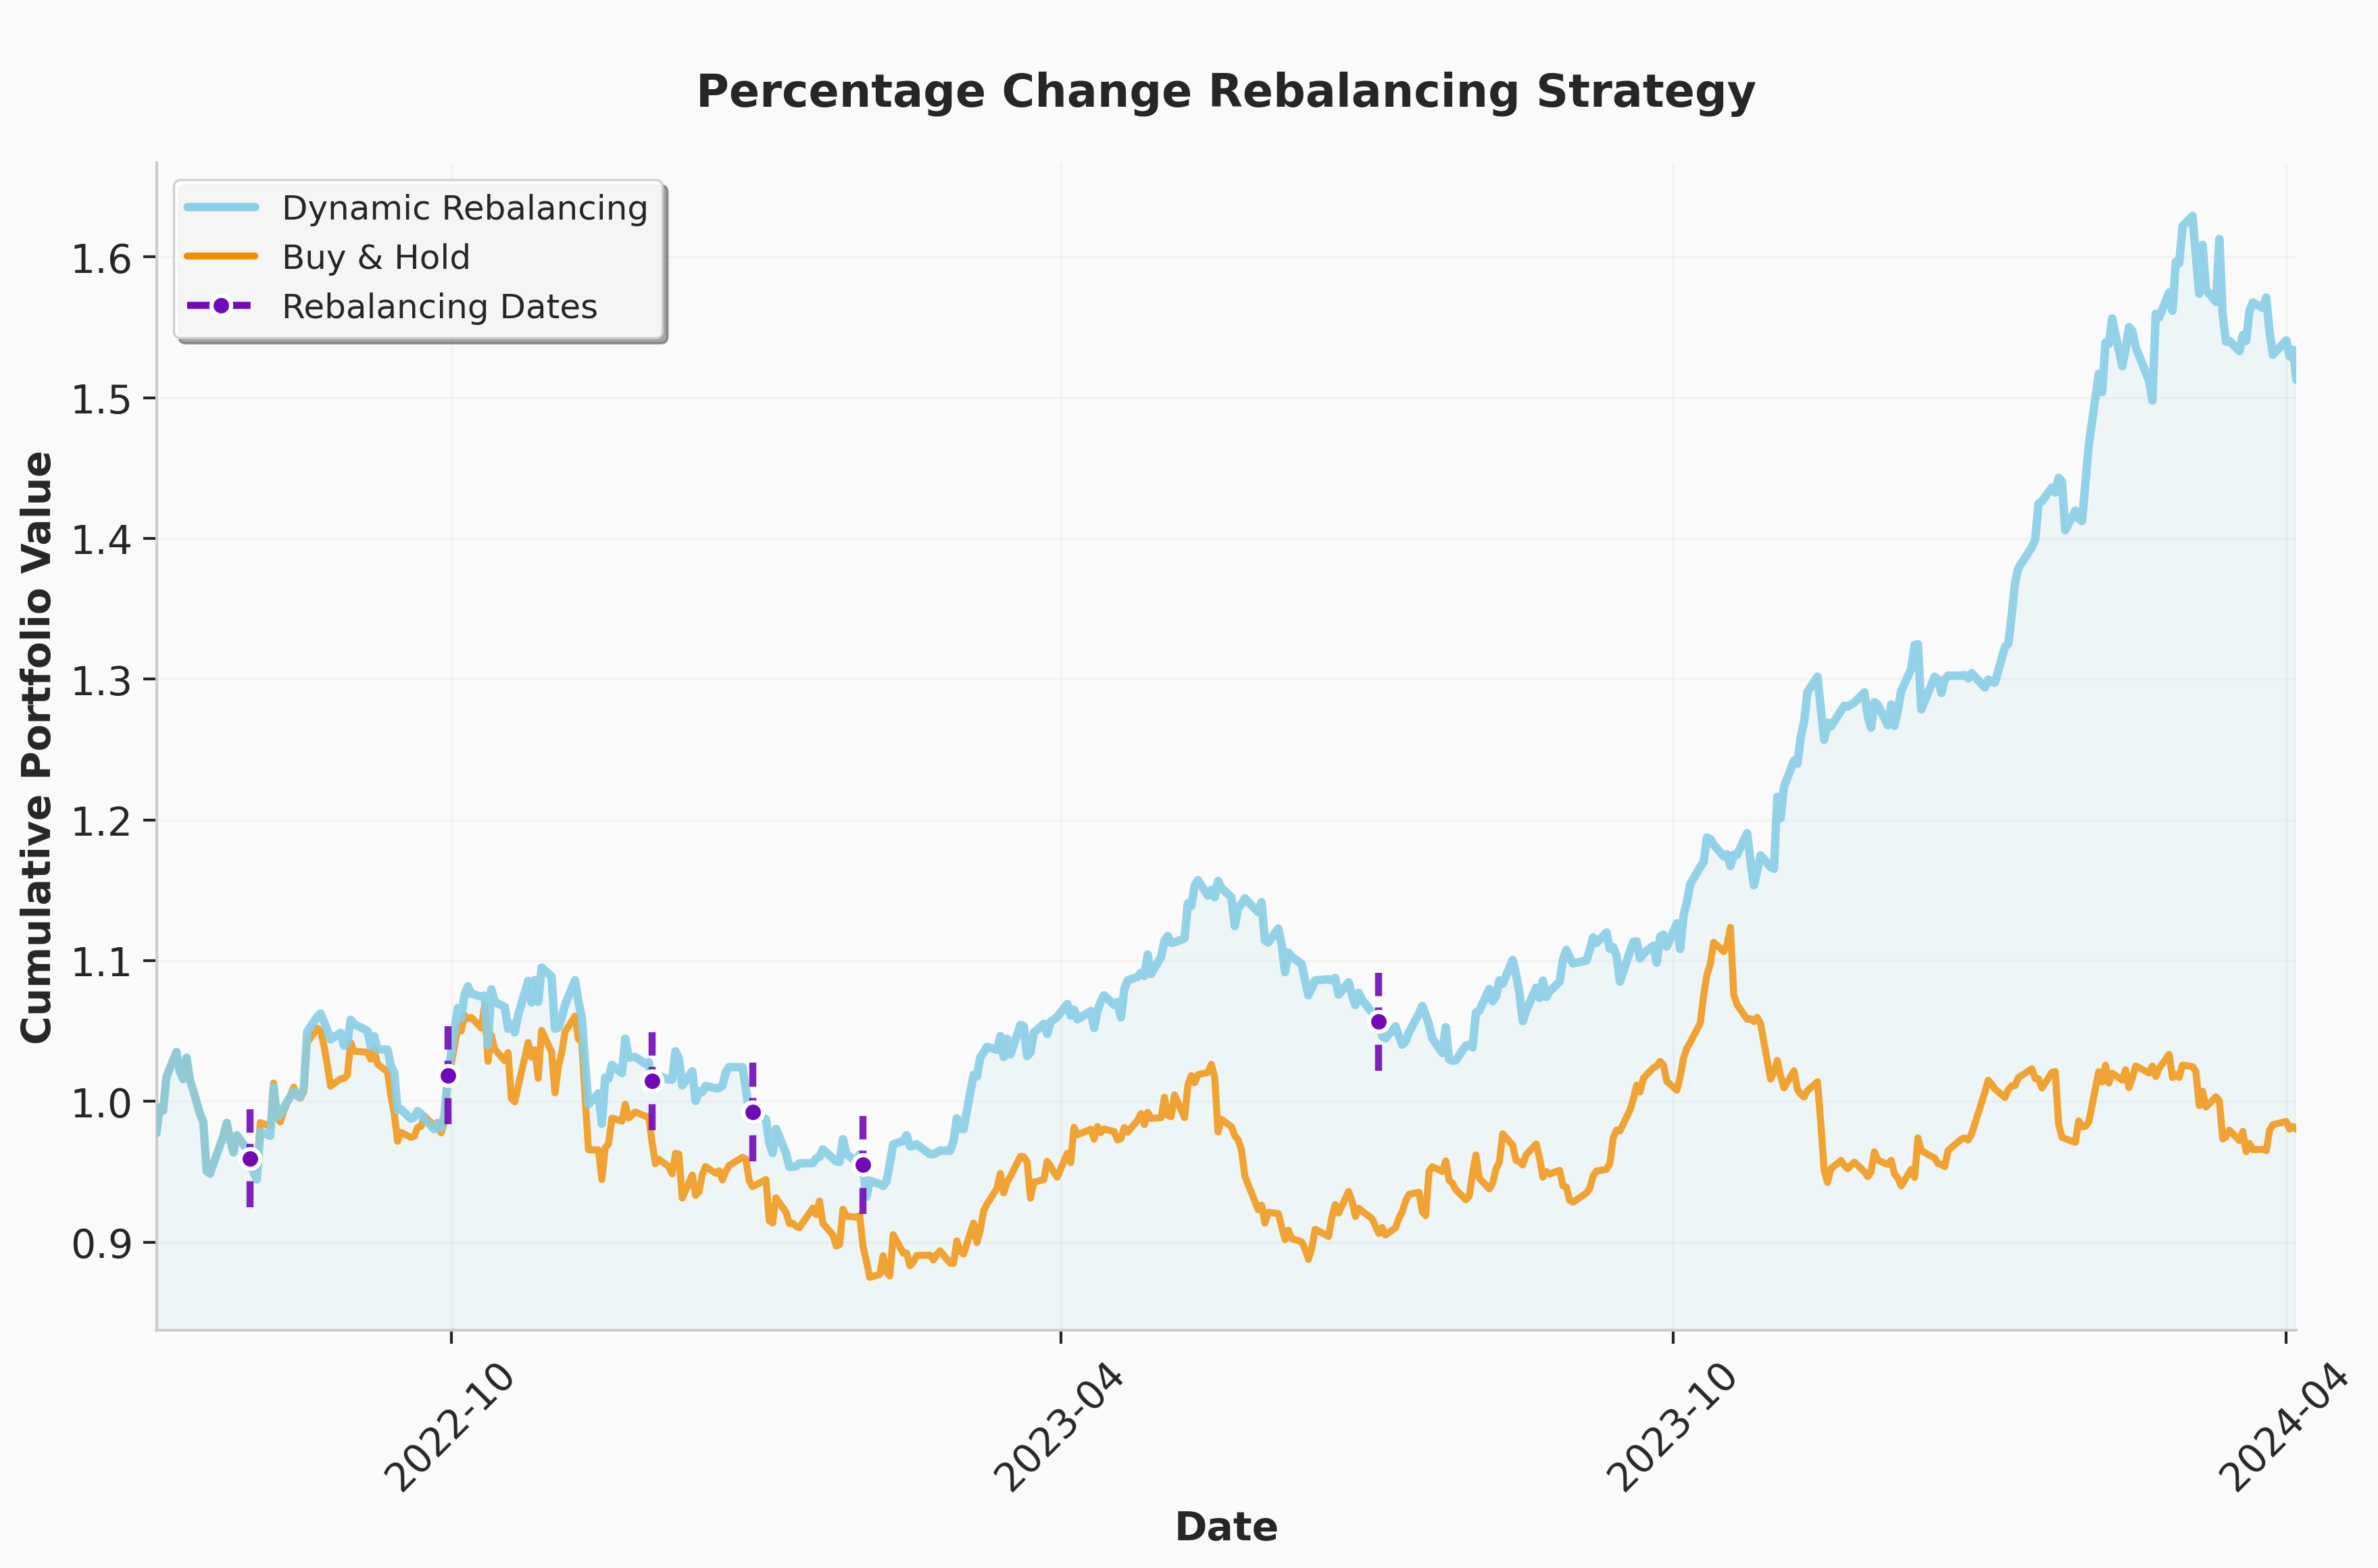

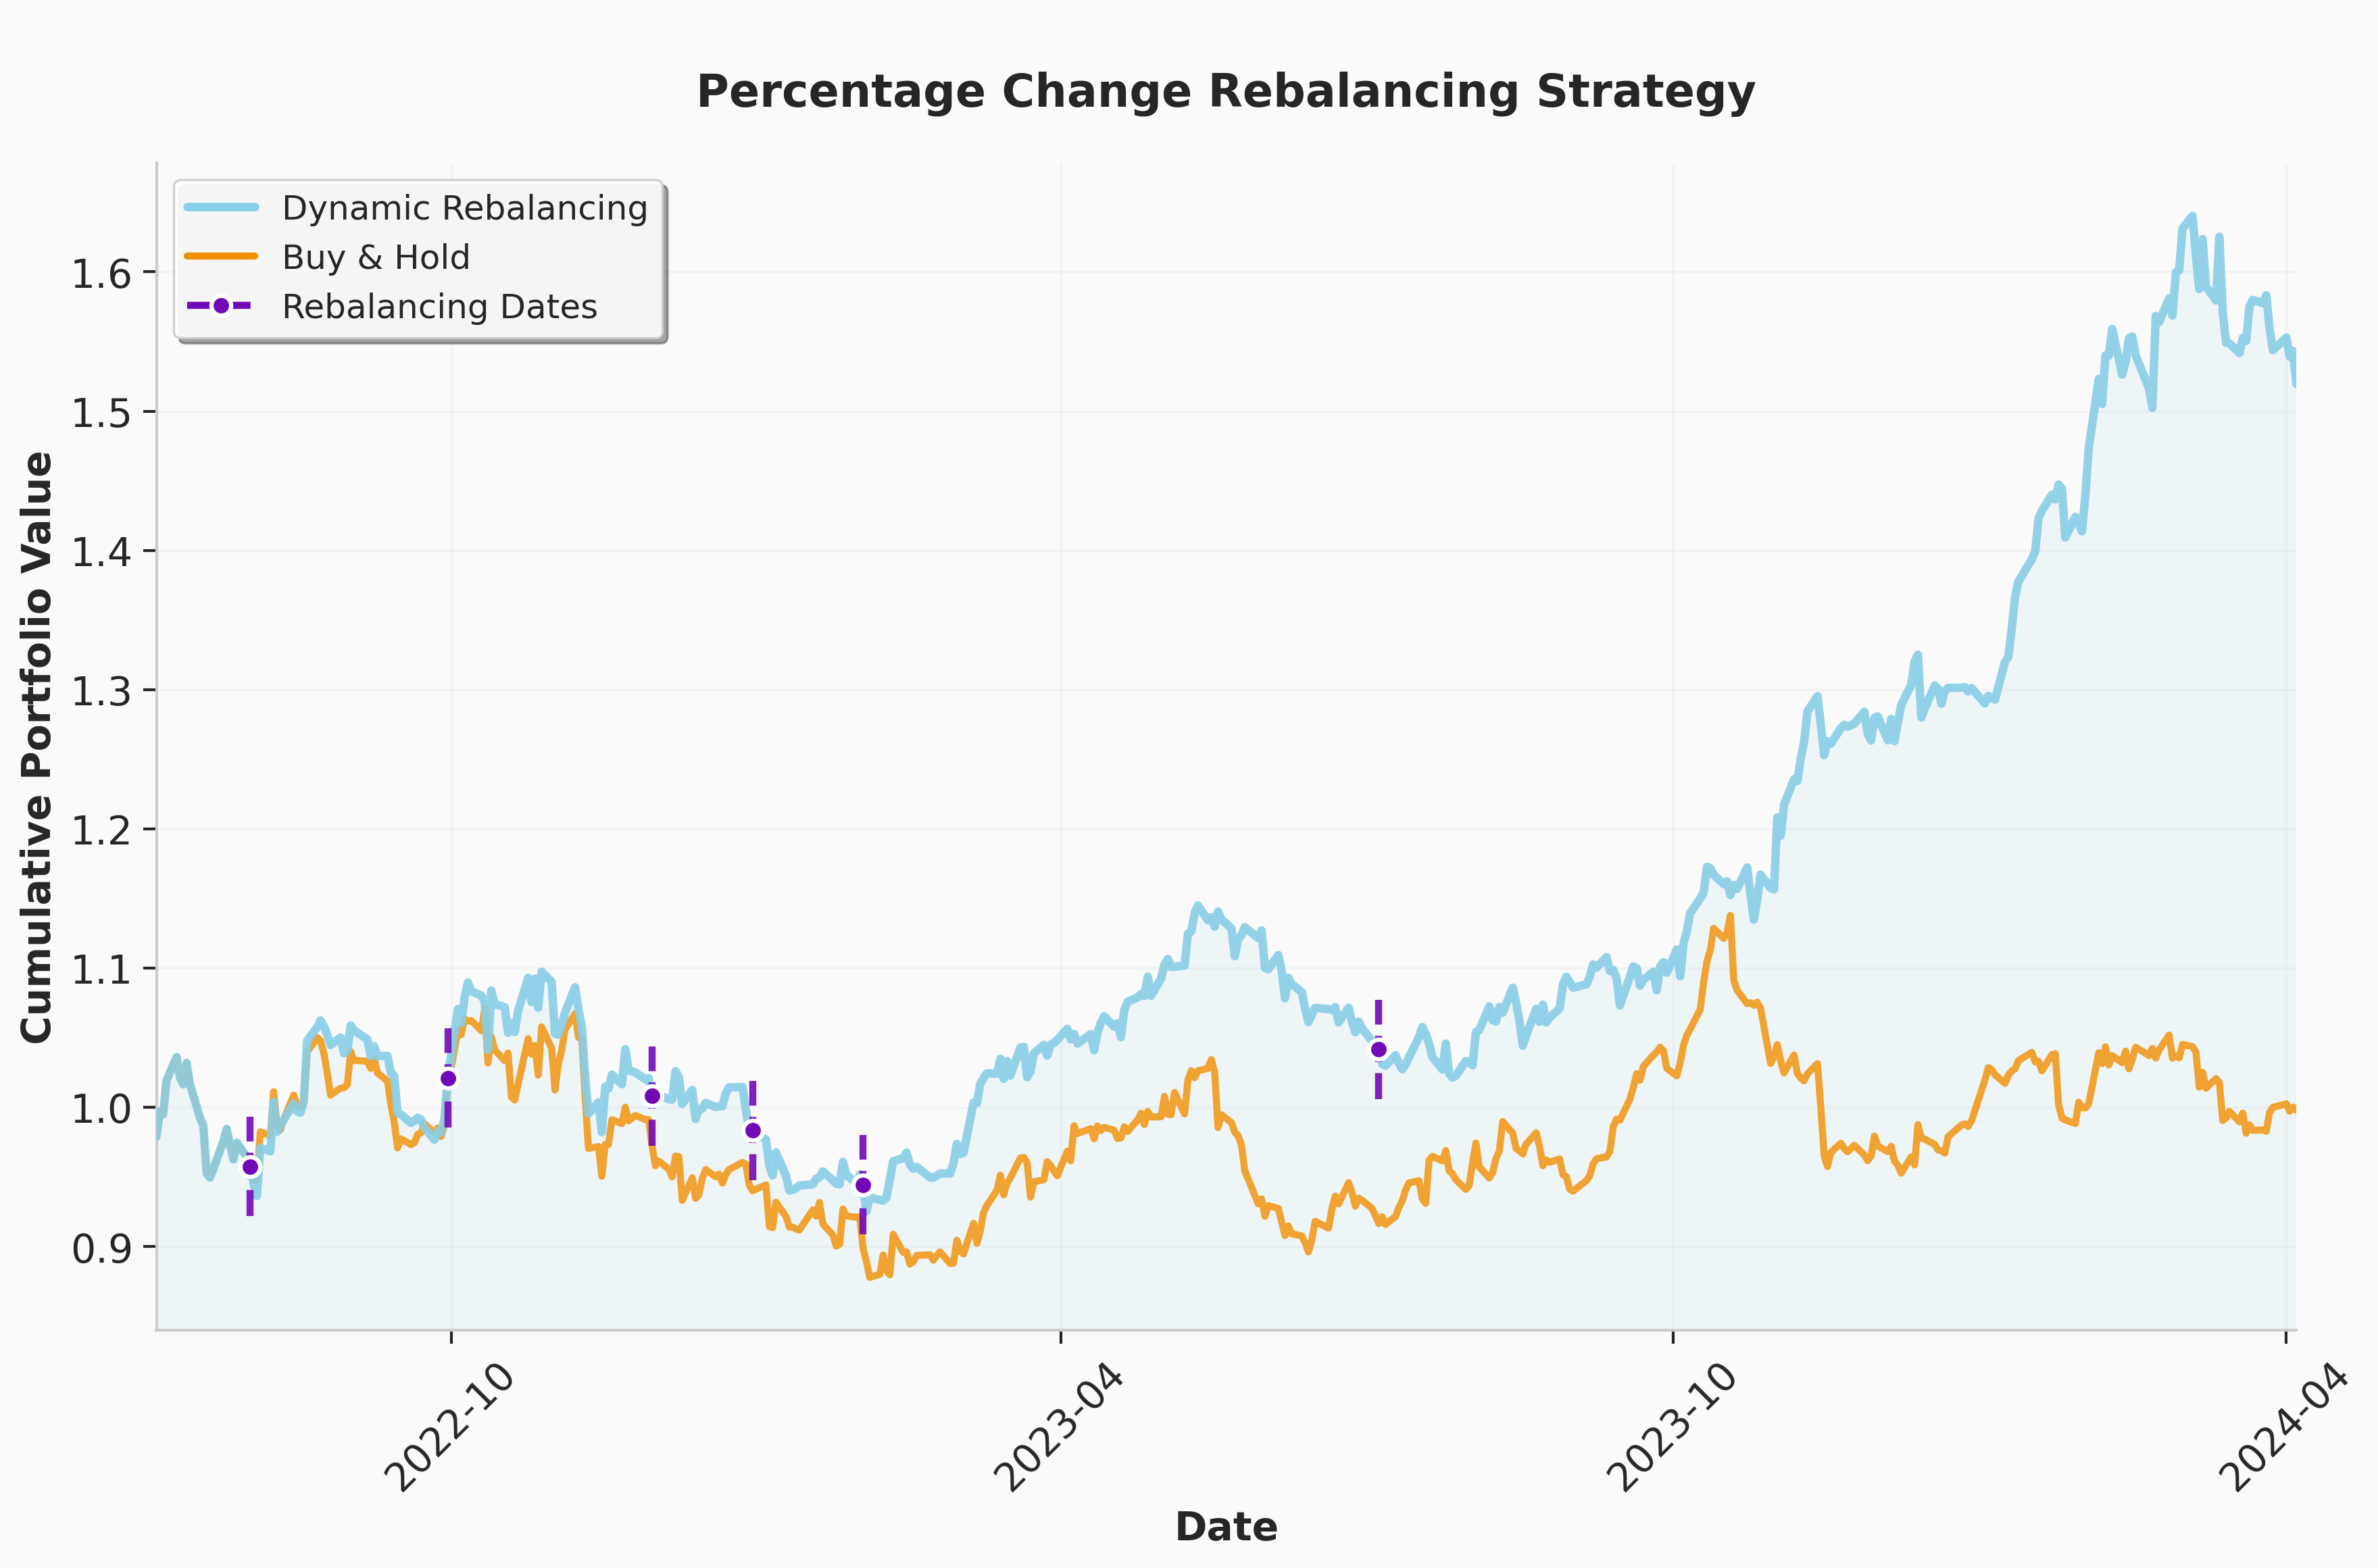

In [4]:
# Trading period and backtesting windows.
selected_rebal_scenario_name = 'rebalancing_trading_period'
rebal_trading_start_date, rebal_trading_end_date = "2022-07-01", "2024-05-01"

rebal_look_back_window = 252       # Historical period for optimization (trading days).
rebal_look_forward_window = 21     # Out-of-sample testing period (trading days).

# Transaction cost parameters
transaction_cost_factor = 0.001

# Reoptimization trigger: percentage change threshold.
percent_change_tolerance = -0.005   # Reoptimize if portfolio value drops by 0.5%.
pct_change_re_optimize_criteria = {"type": "pct_change", "threshold": percent_change_tolerance}

# GPU solver configuration.
solver_settings = {'solver':cp.CUOPT, 'verbose': False}

# Execute portfolio rebalancing with percentage change trigger.
pct_change_rebalancing_obj = rebalance.rebalance_portfolio(
    dataset_directory=sp500_dataset_directory,
    trading_start=rebal_trading_start_date,
    trading_end=rebal_trading_end_date,
    look_forward_window=rebal_look_forward_window,
    look_back_window=rebal_look_back_window,
    cvar_params=rebal_tc_cvar_params,
    solver_settings = solver_settings,
    re_optimize_criteria=pct_change_re_optimize_criteria,
    return_type=log_return_type,
    print_opt_result = False
)

# Retrieve and plot optimization results.
pct_change_results_df, pct_change_re_optimize_dates, cumulative_portfolio_value_array = pct_change_rebalancing_obj.re_optimize(
                                                                                                                        transaction_cost_factor = transaction_cost_factor, \
                                                                                                                        plot_results=True, \
                                                                                                                        save_plot = True, \
                                                                                                                        results_dir = "../results/rebalancing_strategies"
                                                                                                                        )

## Strategy 2: Drift from Optimal Portfolio
<a id='drift-from-optimal'></a>
Portfolio value changes as the asset values in the portfolio changes. Over time, the portfolio composition will deviate from the original optimized portfolio. A re-optimization is triggered if the norm of the difference between current and optimal weights exceeds `drift_tolerance`, i.e. 
$$\lVert w_{cur} - w_{opt} \rVert_* > tol,$$
where:

- $w_{cur}$ = Current portfolio weights
- $w_{pre}$ = Optimal portfolio weights
- $tol$ = `drift_tolerance`
- Norm $*$: 1-norm (absolute differences) or 2-norm (Euclidean distance).

BASELINE (BUY & HOLD) ANALYSIS
Period: 2022-07-01 to 2024-05-01
Strategy: Single optimization at start
Setting parameter log_to_console to false
Setting parameter absolute_dual_tolerance to 1.000000e-04
Setting parameter relative_dual_tolerance to 1.000000e-04
Setting parameter absolute_primal_tolerance to 1.000000e-04
Setting parameter relative_primal_tolerance to 1.000000e-04
Setting parameter absolute_gap_tolerance to 1.000000e-04
Setting parameter relative_gap_tolerance to 1.000000e-04

BASELINE COMPLETE
Final portfolio value: $0.93
Total return: -4.42%
Data points collected: 420

DYNAMIC REBALANCING ANALYSIS
Period: 2022-07-01 to 2024-05-01
Strategy: Drift From Optimal
Threshold: 0.05
Look-forward window: 42 days
Look-back window: 252 days
Setting parameter log_to_console to false
Setting parameter absolute_dual_tolerance to 1.000000e-04
Setting parameter relative_dual_tolerance to 1.000000e-04
Setting parameter absolute_primal_tolerance to 1.000000e-04
Setting parameter relative_

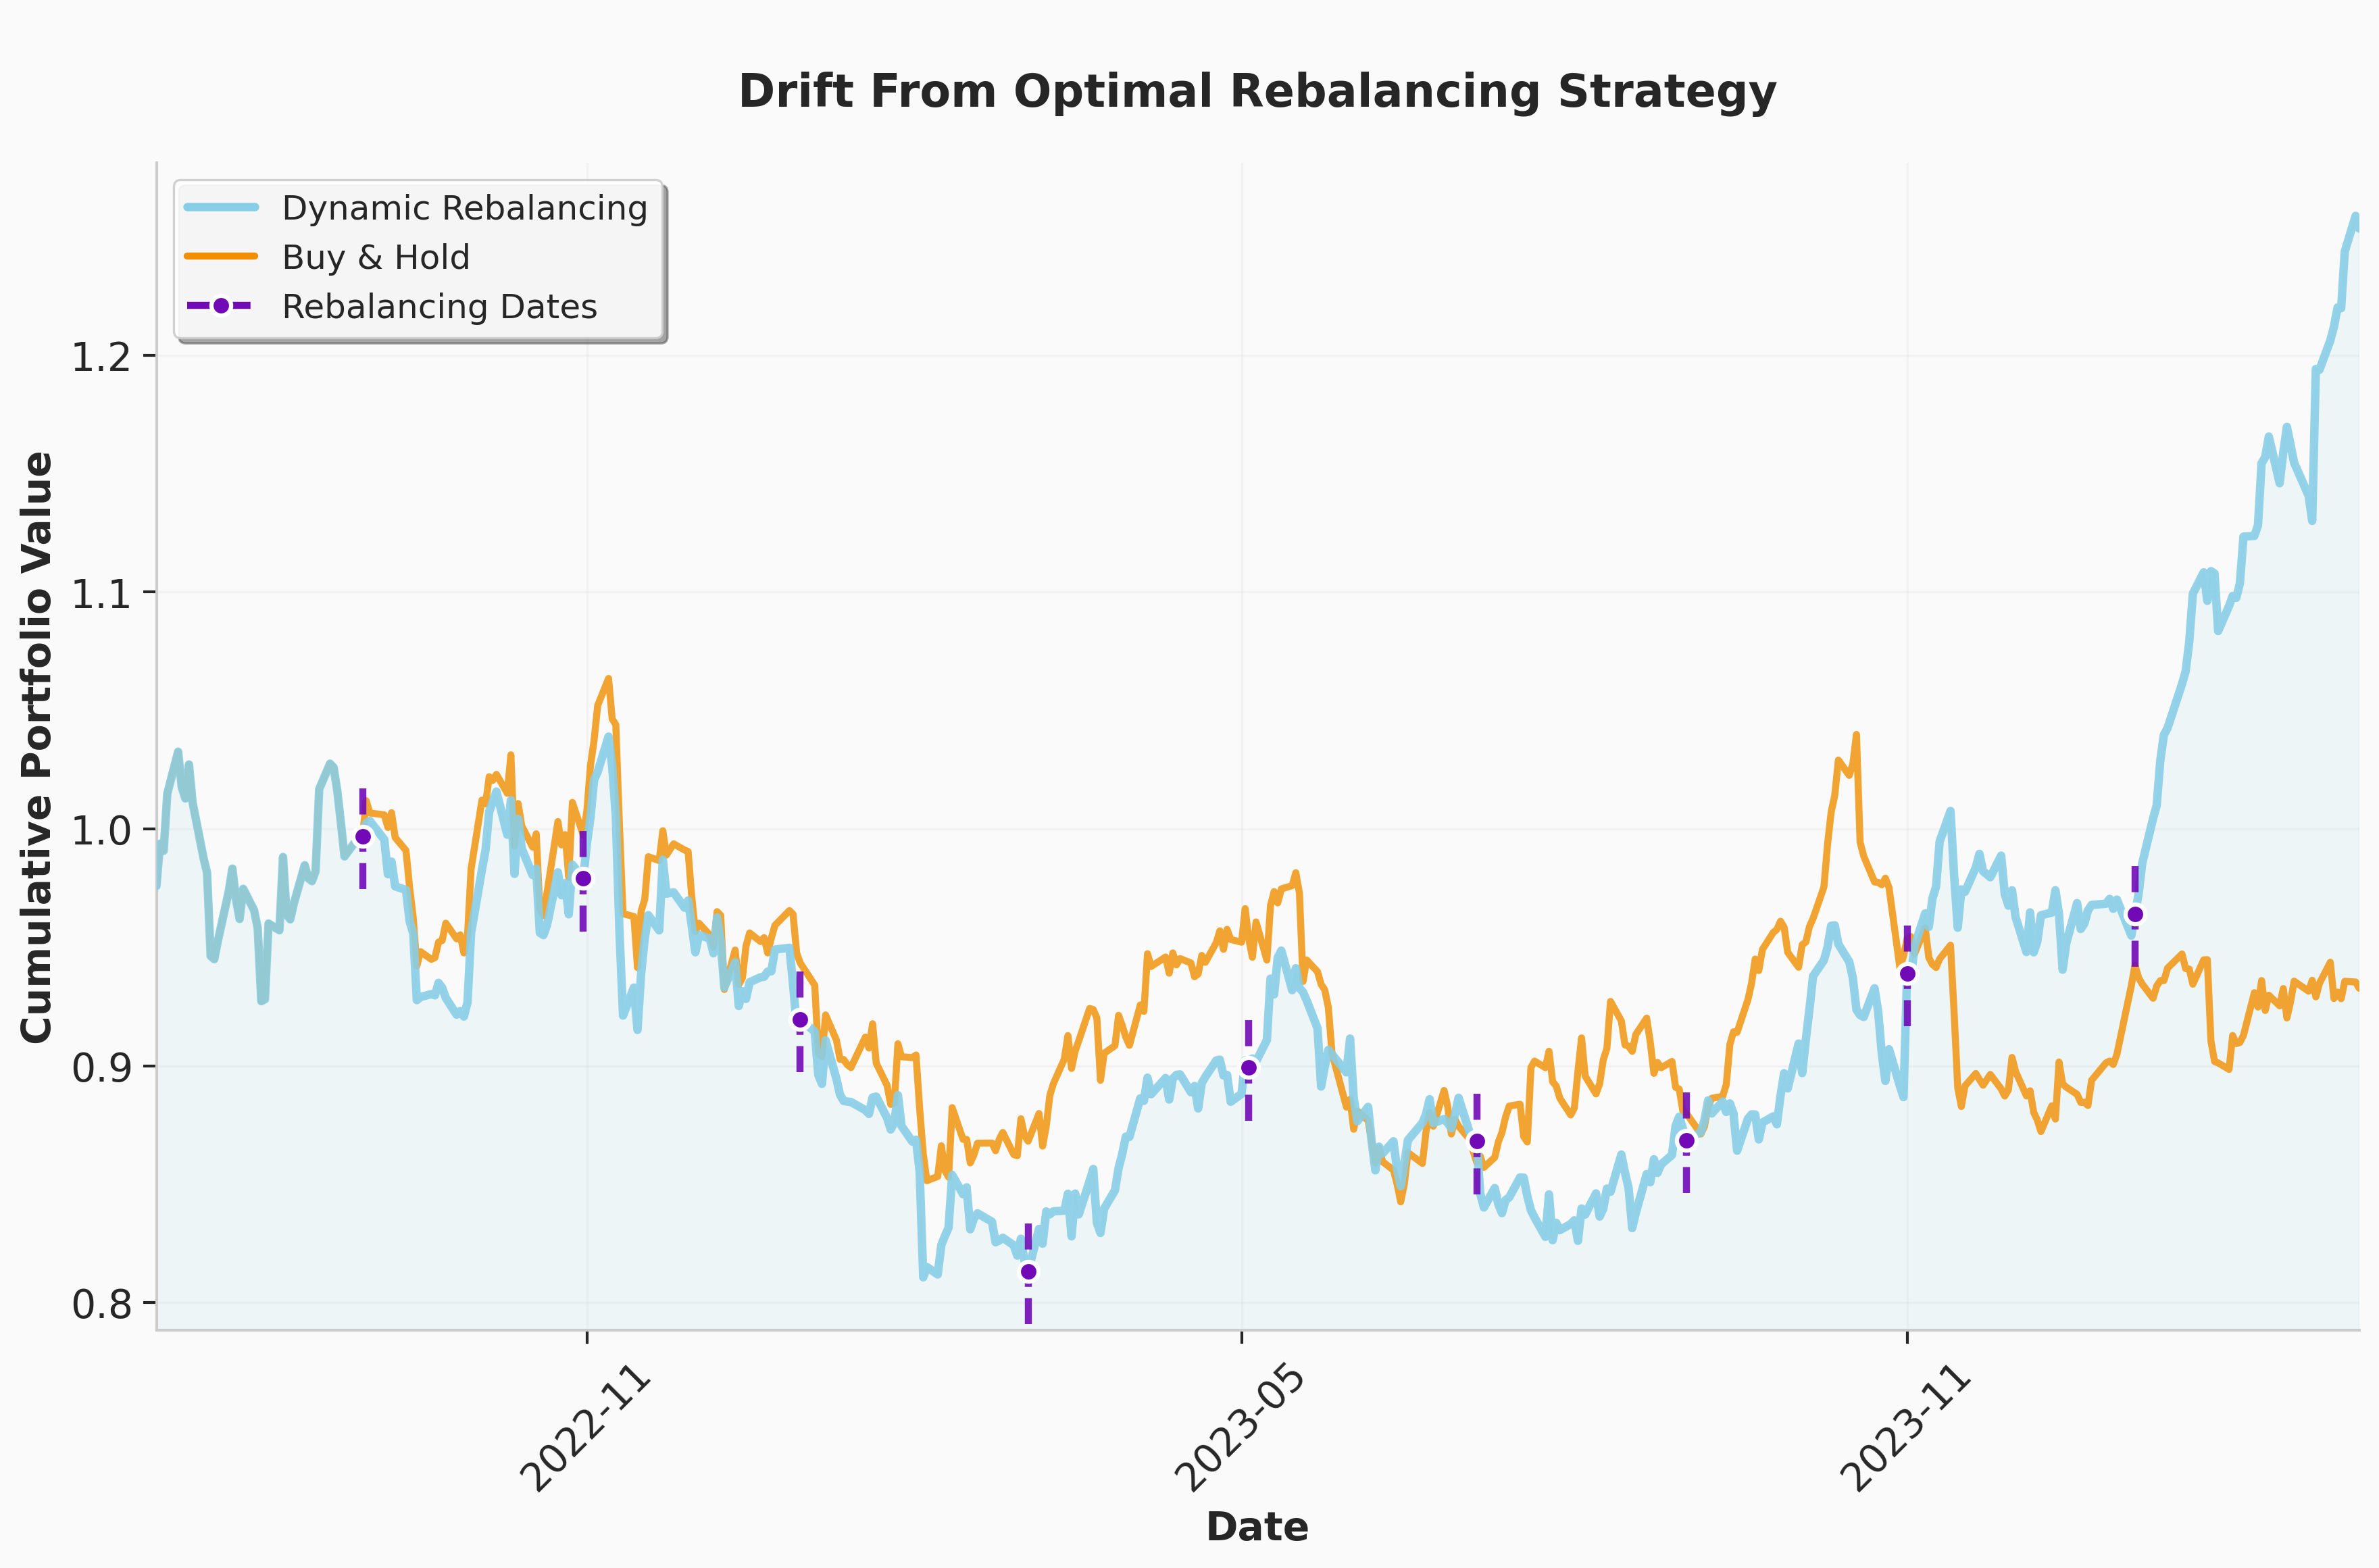

In [5]:
# --- Select Scenario for Rebalancing ---
selected_rebal_scenario_name = 'rebalancing_trading_period'
rebal_trading_start_date, rebal_trading_end_date = "2022-07-01", "2024-05-01"

# Look-back and look-forward windows for backtesting
rebal_look_back_window = 252       # Historical period used for optimization (trading days)
rebal_look_forward_window = 42     # Testing period (out-of-sample performance)

# Define drift tolerance threshold
drift_rebal_tolerance = 0.05        # Rebalance if weight deviation (L2 norm) exceeds tolerance

# Set re-optimization criteria for drift
drift_re_optimize_criteria = {
    "type": "drift_from_optimal",
    "threshold": drift_rebal_tolerance,
    "norm": 1,                # Using L2 norm
}

#GPU solver
solver_settings = {"solver": cp.CUOPT, "verbose": False, 'optimality':1e-4}

# Execute portfolio rebalancing
drift_rebalancing_obj = rebalance.rebalance_portfolio(
    dataset_directory=sp500_dataset_directory,
    trading_start=rebal_trading_start_date,
    trading_end=rebal_trading_end_date,
    look_forward_window=rebal_look_forward_window,
    look_back_window=rebal_look_back_window,
    cvar_params=rebal_tc_cvar_params,
    solver_settings = solver_settings,
    re_optimize_criteria=drift_re_optimize_criteria,
    return_type=log_return_type,
    print_opt_result=False
)

# Retrieve and plot results
drift_results_df, drift_re_optimize_dates, cumulative_portfolio_value_array = drift_rebalancing_obj.re_optimize(plot_results=True, save_plot = True, results_dir = "../results/rebalancing_strategies")

Portfolio optimization is a repeated core task rather than a one‑time effort – the acceleration cuOpt delivers for a single optimization problem will be magnified in active trading environments. There are more sophisticated strategies with more hyperparameters, and searching for the optimal strategy will require repeating the above progress countless times. In other words, these example strategies are only to highlight GPU-Accelerated Portfolio Optimization performance and are not optimized for deployment; to find the optimal strategies, many more iterations of optimization are needed. 
